In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Dense, Add, Flatten, BatchNormalization, Dropout,MaxPooling2D
from tensorflow.keras import Model, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.utils import resample, class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import glob
import matplotlib.pyplot as plt
import PIL
import numpy as np
#import cv2
import os
import tensorflow as tf
import cv2
import sys
import shutil
# Especifica la ruta del archivo
library_path = '/kaggle/input/beasf/other/beasf/1'
sys.path.append(library_path)
from BEASF import BEASF
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score

2024-12-28 16:05:19.339702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 16:05:19.339814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 16:05:19.483729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def data_preparation(pathNormales, pathNeumonia):
    def load_images_from_folder(folder_path, target_size=(1920, 1080)):
        images = []
        image_names = []
        for img_name in glob.glob(folder_path):
            img = load_img(img_name, color_mode='grayscale', target_size=target_size)  # Redimensionar las imágenes
            img = img_to_array(img, data_format='channels_last')
            images.append(img)
            image_names.append(img_name)
        return np.array(images), image_names
    
    def preprocess_images(images):
        images_resized = [cv2.resize(img, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for img in images]
        images_expanded = [np.expand_dims(img, axis=-1) for img in images_resized]
        return np.array(images_expanded, dtype=np.uint8)

    def enhance_images(images):
        X_beasf = np.array([BEASF(image=img, gamma=1.5) for img in images])
        X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img) for img in images])
        X_clahe_expanded = np.array([np.expand_dims(img, axis=-1) for img in X_clahe])
        return np.concatenate((images, X_beasf, X_clahe_expanded), axis=-1)

    # Load images and names
    normal_images, normal_image_names = load_images_from_folder(pathNormales)
    neumonia_images, neumonia_image_names = load_images_from_folder(pathNeumonia)

    print(f'Number of normal chest X-rays: {len(normal_images)}')
    print(f'Number of pneumonia chest X-rays: {len(neumonia_images)}')

    # Create labels
    normal_labels = np.zeros(len(normal_images), dtype=int)
    neumonia_labels = np.ones(len(neumonia_images), dtype=int)

    # Combine images and labels
    X = np.concatenate((neumonia_images, normal_images))
    y = np.concatenate((neumonia_labels, normal_labels))
    
    # Combine image names
    image_names = neumonia_image_names + normal_image_names

    # Preprocess images
    X = preprocess_images(X)

    # Apply enhancements
    X = enhance_images(X)
    
    # Normalize images
    X = X / 255.0

    print(f'Numero total de imagenes del dataset: {len(X)}')
    print(f'Nummero de etiquetas del dataset: {len(y)}')
    print(f'Dataset shape: {X.shape}')

    # Display a random image from the dataset and the original image
    rnd_idx = np.random.choice(len(X))

    # Load the original image
    original_img = load_img(image_names[rnd_idx], color_mode='grayscale')
    original_img = img_to_array(original_img, data_format='channels_last')

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Display the original image
    axes[0].imshow(original_img.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'Imagen original')
    # Display the processed image
    axes[1].imshow(X[rnd_idx].squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Imagen Procesada')

    plt.show()
    print(f'Imagen original: {image_names[rnd_idx]}')

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
def model(input_shape):
    a0 = Input(shape=input_shape, name='input_layer')
    a1 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv_layer1')(a0)
    a2 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer1')(a1)
    a2_drop = Dropout(rate=0.25, name='dropout_layer1')(a2)  # Dropout after first MaxPooling
    
    a3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv_layer2')(a2_drop)
    a4 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer2')(a3)
    a4_drop = Dropout(rate=0.25, name='dropout_layer2')(a4)  # Dropout after second MaxPooling
    
    a5 = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='conv_layer3')(a4_drop)
    a6 = MaxPooling2D(pool_size=(2, 2), name='maxpool_layer3')(a5)
    a6_drop = Dropout(rate=0.25, name='dropout_layer3')(a6)  # Dropout after third MaxPooling
    
    a7 = Flatten(name='flatten_layer')(a6_drop)
    a8 = Dense(units=128, activation='relu', name='fc_layer1')(a7)
    a9 = Dense(units=64, activation='relu', name='fc_layer2')(a8)
    a10 = Dense(units=1, activation='sigmoid', name='output_layer')(a9)
    
    return Model(inputs=a0, outputs=a10, name='binary_classifier')

Number of normal chest X-rays: 347
Number of pneumonia chest X-rays: 346
Numero total de imagenes del dataset: 693
Nummero de etiquetas del dataset: 693
Dataset shape: (693, 320, 320, 3)


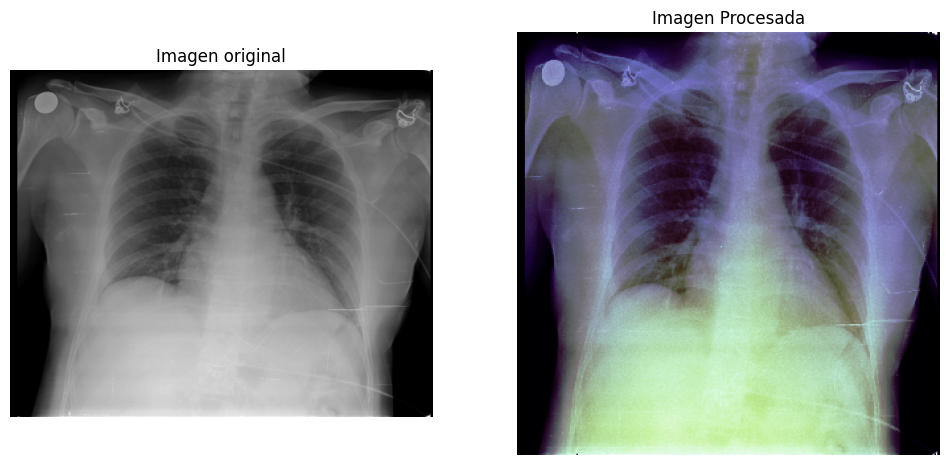

Imagen original: /kaggle/input/imagenesnormalesnormalizadas/216840111366964013590140476722013066084652782_02-047-129.png


In [5]:
X_train, X_test, y_train, y_test = data_preparation('/kaggle/input/imagenesnormalesnormalizadas/*','/kaggle/input/imagenesneumonianormalizadas/*')

Number of normal chest X-rays: 975
Number of pneumonia chest X-rays: 346
Numero total de imagenes del dataset: 1321
Nummero de etiquetas del dataset: 1321
Dataset shape: (1321, 320, 320, 3)


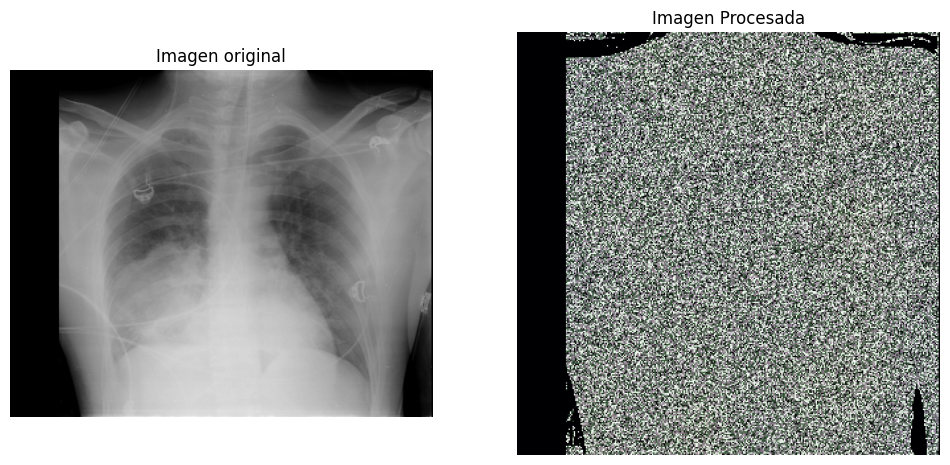

Imagen original: /kaggle/input/imagenes-con-neumonia/116370741584789332749301211117591106182_qjp9k7.png


In [3]:
#Desbalanceo
X_train_desbalanceo, X_test_desbalanceo, y_train_desbalanceo, y_test_desbalanceo = data_preparation('/kaggle/input/imagenes-sin-neumonia/*','/kaggle/input/imagenes-con-neumonia/*')

In [7]:
# Obtener el número de imágenes en cada conjunto
num_train_images = len(X_train)
num_test_images = len(X_test)
num_train_labels = len(y_train)
num_test_labels = len(y_test)

# Imprimir los resultados
print(f"Número de imágenes en X_train: {num_train_images}")
print(f"Número de imágenes en X_test: {num_test_images}")
print(f"Número de etiquetas en y_train: {num_train_labels}")
print(f"Número de etiquetas en y_test: {num_test_labels}")

Número de imágenes en X_train: 554
Número de imágenes en X_test: 139
Número de etiquetas en y_train: 554
Número de etiquetas en y_test: 139


In [8]:
# Obtener el número de imágenes en cada conjunto desbalanceado
num_train_images_desbalanceo = len(X_train_desbalanceo)
num_test_images_desbalanceo = len(X_test_desbalanceo)
num_train_labels_desbalanceo = len(y_train_desbalanceo)
num_test_labels_desbalanceo = len(y_test_desbalanceo)

# Imprimir los resultados del conjunto desbalanceado
print(f"Número de imágenes en X_train: {num_train_images_desbalanceo}")
print(f"Número de imágenes en X_test: {num_test_images_desbalanceo}")
print(f"Número de etiquetas en y_train: {num_train_labels_desbalanceo}")
print(f"Número de etiquetas en y_test: {num_test_labels_desbalanceo}")

Número de imágenes en X_train: 1056
Número de imágenes en X_test: 265
Número de etiquetas en y_train: 1056
Número de etiquetas en y_test: 265


In [6]:
"""model callbacks"""
#Remover los directorios donde se encuentran guardados los modelos de entrenamientos previos
# Define the directory paths
directories = [
    "/kaggle/working/model1",
    "/kaggle/working/model2"
]

# Iterate over each directory and remove it if it exists
for directory in directories:
    if os.path.exists(directory):
        shutil.rmtree(directory)
        
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model1/checkpoints/base_model/v_free/eps={epoch:03d}_valLoss={val_loss:.4f}.keras',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

checkpoint2 = ModelCheckpoint(filepath='/kaggle/working/model2/checkpoints/base_model/v_free/eps={epoch:03d}_valLoss={val_loss:.4f}.keras',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', verbose=1, min_delta=0.002)
#cb_list = [checkpoint, early_stopping]

In [10]:
"""Modelo principal"""
input_shape = X_train.shape[1:]  # Toma la forma de una muestra de X_train excluyendo el primer eje (el número de muestras)
classifier = model(input_shape=input_shape)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(classifier.summary())
print('Numero de capas del modelo:', len(classifier.layers))


Model: "binary_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer1 (Conv2D)            │ (None, 320, 320, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer1 (MaxPooling2D)   │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer2 (Conv2D)            │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer2 (MaxPooling2D)   │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer2 (Dropout)        │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer3 (Conv2D)            │ (None, 80, 80, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer3 (MaxPooling2D)   │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer3 (Dropout)        │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 819200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer1 (Dense)               │ (None, 128)            │   104,857,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,532,033 (402.57 MB)

 Trainable params: 105,532,033 (402.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Numero de capas del modelo: 14


In [15]:
# Entrenar el modelo principal
history = classifier.fit(x=X_train, y=y_train, 
                         callbacks=[checkpoint,early_stopping],
                         epochs=100,
                         batch_size=32,
                         verbose=1, 
                         validation_data=(X_test, y_test))


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9899 - loss: 0.1104
Epoch 1: val_loss did not improve from 2.11406
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9890 - loss: 0.1775 - val_accuracy: 0.6259 - val_loss: 4.9050
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9892 - loss: 0.2785
Epoch 2: val_loss did not improve from 2.11406
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9883 - loss: 0.4779 - val_accuracy: 0.6835 - val_loss: 55.5467
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9835 - loss: 0.0704
Epoch 3: val_loss did not improve from 2.11406
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9833 - loss: 0.0997 - val_accuracy: 0.6835 - val_loss: 15.2860
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9936 - loss: 0.8934
Epoch 4: val_loss did not improve from 2.11406
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9930 - loss: 1.6729 - val_accuracy: 0.6619 - val_loss: 6

In [7]:
"""Modelo 2"""
input_shape = X_train_desbalanceo.shape[1:]  # Toma la forma de una muestra de X_train excluyendo el primer eje (el número de muestras)
classifier2 = model(input_shape=input_shape)
classifier2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(classifier2.summary())
print('Numero de capas del modelo 2:', len(classifier2.layers))


Model: "binary_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer1 (Conv2D)            │ (None, 320, 320, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer1 (MaxPooling2D)   │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer2 (Conv2D)            │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer2 (MaxPooling2D)   │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer2 (Dropout)        │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer3 (Conv2D)            │ (None, 80, 80, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer3 (MaxPooling2D)   │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer3 (Dropout)        │ (None, 40, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 819200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer1 (Dense)               │ (None, 128)            │   104,857,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_layer2 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,532,033 (402.57 MB)

 Trainable params: 105,532,033 (402.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Numero de capas del modelo 2: 14


In [ ]:
# Entrenar el modelo 2
history2 = classifier2.fit(x=X_train_desbalanceo, y=y_train_desbalanceo, 
                         callbacks=[checkpoint2,early_stopping],
                         epochs=100,
                         batch_size=32,
                         verbose=1, 
                         validation_data=(X_test_desbalanceo, y_test_desbalanceo))

In [16]:
#Carga de los mejores modelos 
# Obtener el archivo del mejor modelo guardado - Modelo principal
model_files = glob.glob(os.path.join('/kaggle/working/model1/checkpoints/base_model/v_free/', '*.keras'))
best_model_file = max(model_files, key=os.path.getctime)  # Selecciona el archivo más reciente
best_model = load_model(best_model_file)

# Obtener el archivo del mejor modelo 2
model2_files = glob.glob(os.path.join('/kaggle/working/model2/checkpoints/base_model/v_free/', '*.keras'))
best_model2_file = max(model2_files, key=os.path.getctime)  # Selecciona el archivo más reciente
best_model2 = load_model(best_model2_file)





In [18]:
# Realizar predicciones en los datos de prueba para cada modelo
#Modelo 1
y_pred = best_model.predict(X_test)
y_pred2 = best_model2.predict(X_test_desbalanceo)
# Convertir las predicciones en etiquetas binarias (0 o 1)
y_pred_binary = (y_pred > 0.5).astype(int)
y_pred2_binary = (y_pred2 > 0.5).astype(int)
# Imprimir las primeras 10 predicciones y sus etiquetas reales por cada modelo
print("\n ============ Primeras 10 predicciones =============")
print("Predicciones Modelo principal :", y_pred_binary[:20].flatten())
print("Predicciones Modelo 2:", y_pred2_binary[:20].flatten())
print("Etiquetas reales (primeras 10):", y_test[:20])
print("Etiquetas reales desbalanceadas (primeras 10):", y_test_desbalanceo[:20])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step

 ============ Primeras 10 predicciones =============
Predicciones Modelo principal : [0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1]
Predicciones Modelo 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Etiquetas reales (primeras 10): [0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0]
Etiquetas reales desbalanceadas (primeras 10): [0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [24]:
# Calcular métricas de evaluación para cada modelo
# Modelo principal
accuracy1 = accuracy_score(y_test, y_pred_binary) * 100
precision1 = precision_score(y_test, y_pred_binary) * 100
recall1 = recall_score(y_test, y_pred_binary) * 100
f1_1 = f1_score(y_test, y_pred_binary) * 100

# Modelo 2
accuracy2 = accuracy_score(y_test_desbalanceo, y_pred2_binary) * 100
precision2 = precision_score(y_test_desbalanceo, y_pred2_binary) * 100
recall2 = recall_score(y_test_desbalanceo, y_pred2_binary) * 100
f1_2 = f1_score(y_test_desbalanceo, y_pred2_binary) * 100


#Calculo de ROC-AUC
y_pred_model1_probs = classifier.predict(X_test)
roc_model1_auc = roc_auc_score(y_test, y_pred_model1_probs)

y_pred_model2_probs = classifier2.predict(X_test_desbalanceo)
roc_model2_auc = roc_auc_score(y_test_desbalanceo, y_pred_model2_probs)


# Crear una tabla con pandas
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score','ROC-AUC'],
    'Modelo principal': [accuracy1, precision1, recall1, f1_1,roc_model1_auc ],
    'Model principal datos desbalanceados': [accuracy2, precision2, recall2, f1_2, roc_model2_auc]
}
df = pd.DataFrame(data)

# Aplicar estilo a la tabla
styled_df = df.style.set_table_styles(
    [{'selector': 'tr:hover',
      'props': [('background-color', '#ffff99')]},
     {'selector': 'th',
      'props': [('background-color', '#0000ff'),
                ('color', 'white')]},
     {'selector': 'td',
      'props': [('border', '1px solid black')]}]
).format(precision=3)

# Mostrar la tabla con estilo
styled_df


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


,Metric,Modelo principal,Model principal datos desbalanceados
0,Accuracy,76.259,70.943
1,Precision,77.500,11.111
2,Recall,80.519,1.429
3,F1 Score,78.981,2.532
4,ROC-AUC,0.766,0.615


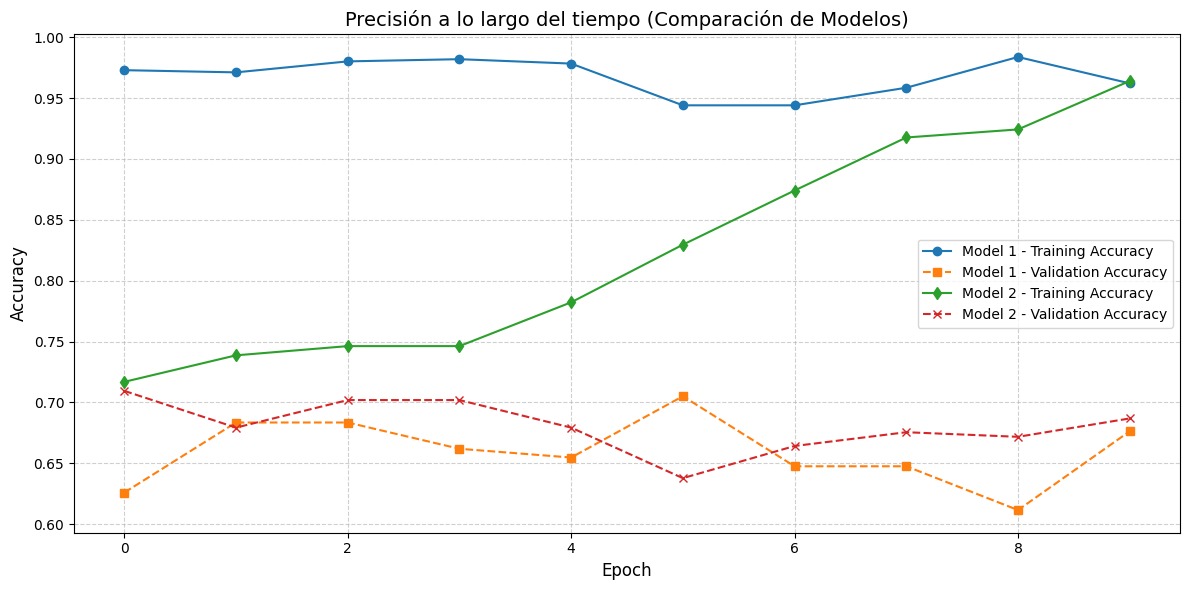

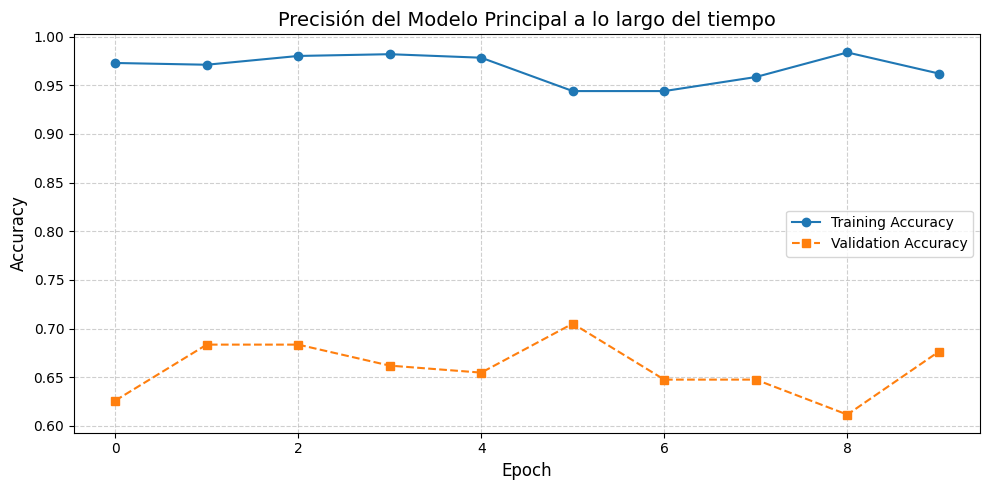

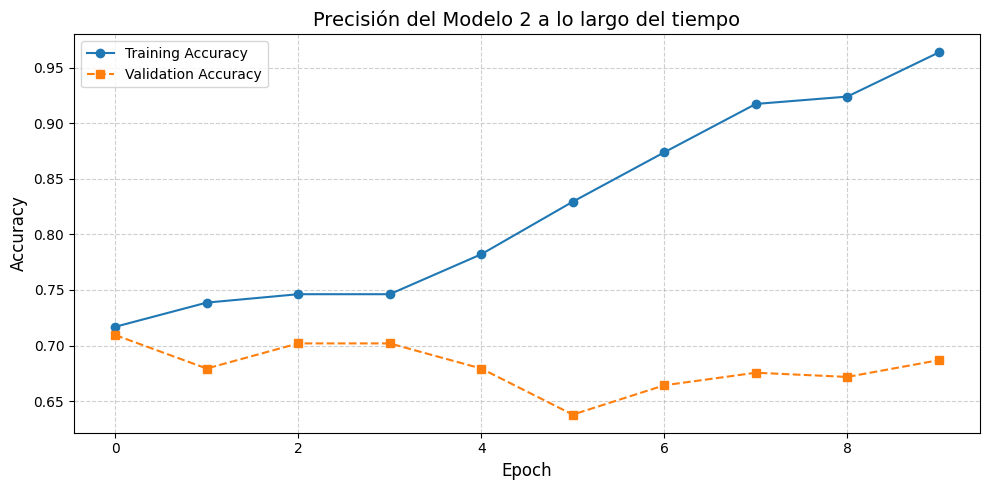

In [28]:
# Obtener la precisión del entrenamiento y la precisión de la validación del historial
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

# Comparación de modelos
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Model 1 - Training Accuracy', linestyle='-', marker='o')
plt.plot(val_accuracy, label='Model 1 - Validation Accuracy', linestyle='--', marker='s')
plt.plot(train_accuracy2, label='Model 2 - Training Accuracy', linestyle='-', marker='d')
plt.plot(val_accuracy2, label='Model 2 - Validation Accuracy', linestyle='--', marker='x')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Precisión a lo largo del tiempo (Comparación de Modelos)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Gráficos individuales
for model_num, (train_acc, val_acc, model_title) in enumerate(
    [(train_accuracy, val_accuracy, 'Modelo Principal'),
     (train_accuracy2, val_accuracy2, 'Modelo 2')], start=1):
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy', linestyle='-', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', linestyle='--', marker='s')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'Precisión del {model_title} a lo largo del tiempo', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()



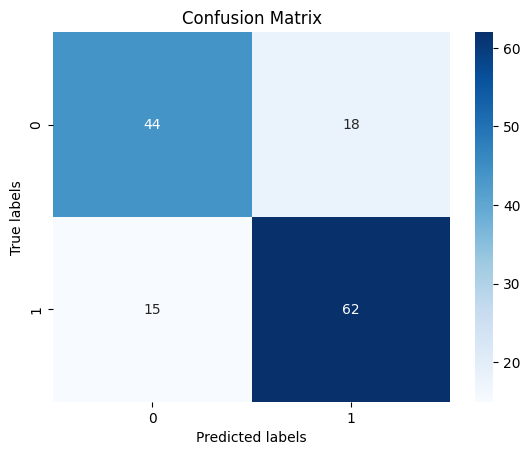

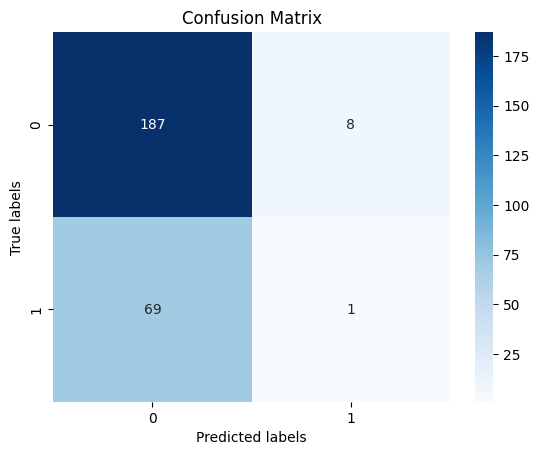

In [29]:
# Calcular la matriz de confusión
#Model principal
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Visualizar la matriz de confusión usando seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#Model 2
conf_matrix2 = confusion_matrix(y_test_desbalanceo, y_pred2_binary)

# Visualizar la matriz de confusión usando seaborn
sns.heatmap(conf_matrix2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


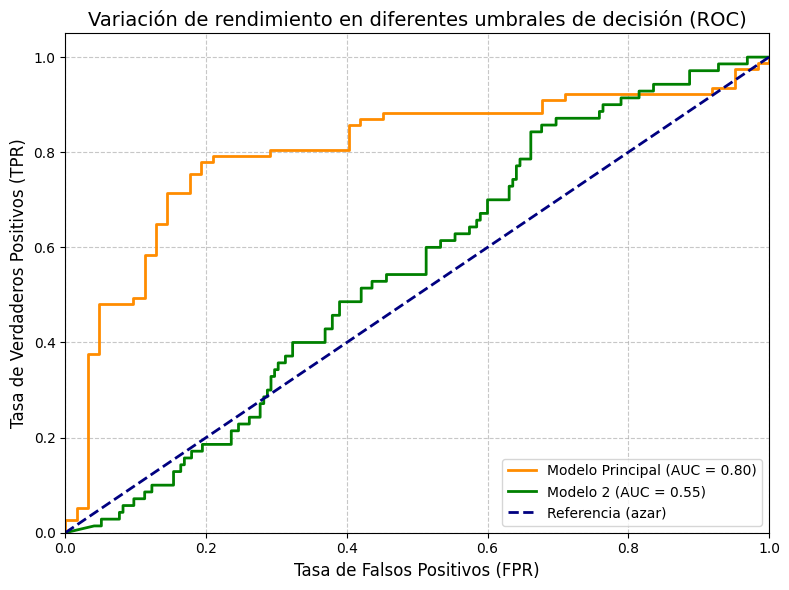

Detalles del Modelo Principal:
- Área bajo la curva (AUC): 0.8025
- Número de umbrales: 43


Detalles del Modelo 2:
- Área bajo la curva (AUC): 0.5514
- Número de umbrales: 103


In [33]:

# Calcular las curvas ROC y las áreas bajo la curva (AUC)
# Modelo Principal
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred)
roc_auc1 = auc(fpr1, tpr1)

# Modelo 2
fpr2, tpr2, thresholds2 = roc_curve(y_test_desbalanceo, y_pred2)
roc_auc2 = auc(fpr2, tpr2)

# Crear un gráfico detallado con ambas curvas ROC
plt.figure(figsize=(8, 6))

# Curva ROC del Modelo Principal
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Modelo Principal (AUC = %0.2f)' % roc_auc1)

# Curva ROC del Modelo 2
plt.plot(fpr2, tpr2, color='green', lw=2, label='Modelo 2 (AUC = %0.2f)' % roc_auc2)

# Línea de referencia (azar)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Referencia (azar)')

# Personalización del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Variación de rendimiento en diferentes umbrales de decisión (ROC)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir detalles adicionales de los modelos
print("Detalles del Modelo Principal:")
print(f"- Área bajo la curva (AUC): {roc_auc1:.4f}")
print(f"- Número de umbrales: {len(thresholds1)}")
print("\n")

print("Detalles del Modelo 2:")
print(f"- Área bajo la curva (AUC): {roc_auc2:.4f}")
print(f"- Número de umbrales: {len(thresholds2)}")

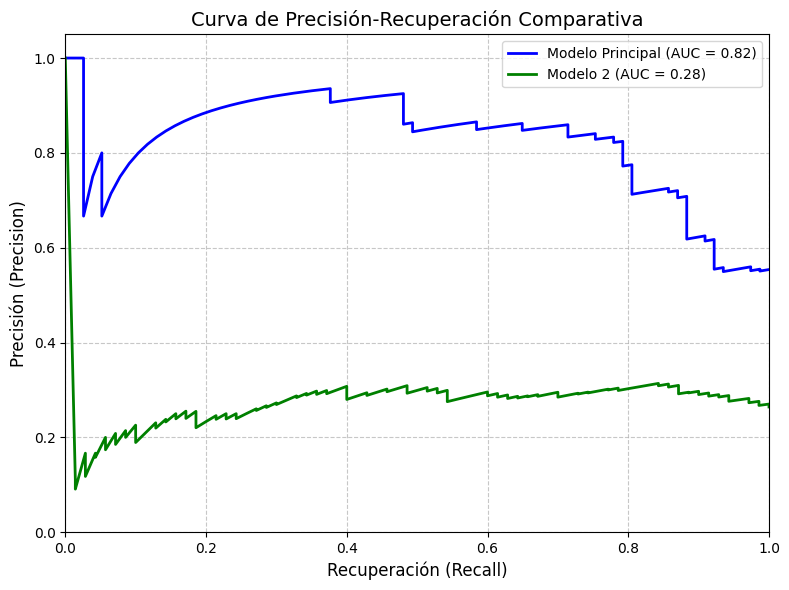

Detalles del Modelo Principal:
- Área bajo la curva (AUC-PR): 0.8205

Detalles del Modelo 2:
- Área bajo la curva (AUC-PR): 0.2758



In [39]:
from sklearn.metrics import precision_recall_curve

# Calcular la curva de precisión-recuperación para los tres modelos
precision1, recall1, _ = precision_recall_curve(y_test, y_pred)
precision2, recall2, _ = precision_recall_curve(y_test_desbalanceo, y_pred2)

# Calcular el área bajo la curva (AUC) de precisión-recuperación
pr_auc1 = auc(recall1, precision1)
pr_auc2 = auc(recall2, precision2)

# Crear un gráfico detallado con las curvas de precisión-recuperación
plt.figure(figsize=(8, 6))

# Curva de precisión-recuperación del Modelo 1
plt.plot(recall1, precision1, color='blue', lw=2, label=f'Modelo Principal (AUC = {pr_auc1:.2f})')

# Curva de precisión-recuperación del Modelo 2
plt.plot(recall2, precision2, color='green', lw=2, label=f'Modelo 2 (AUC = {pr_auc2:.2f})')

# Configuración del gráfico
plt.xlabel('Recuperación (Recall)', fontsize=12)
plt.ylabel('Precisión (Precision)', fontsize=12)
plt.title('Curva de Precisión-Recuperación Comparativa', fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Imprimir detalles adicionales para cada modelo
print("Detalles del Modelo Principal:")
print(f"- Área bajo la curva (AUC-PR): {pr_auc1:.4f}\n")

print("Detalles del Modelo 2:")
print(f"- Área bajo la curva (AUC-PR): {pr_auc2:.4f}\n")


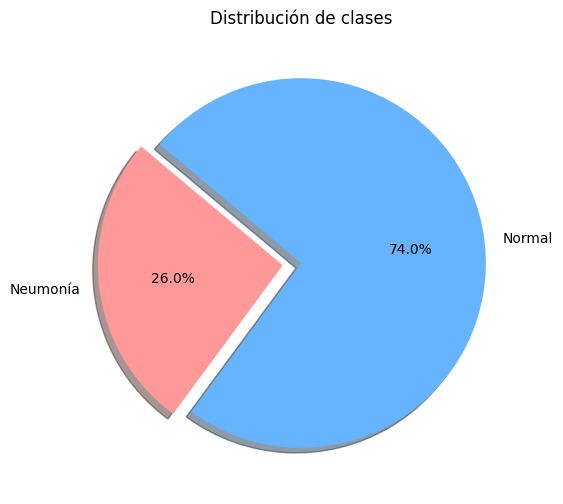

In [40]:
# Distribución desbalanceada
path_neumonia = '/kaggle/input/imagenesneumonianormalizadas'
path_normal = '/kaggle/input/imagenesnormalesnormalizadas'

num_neumonia = 1321*0.26
num_normal = 1321-num_neumonia

# Crear gráfico de pastel
labels = ['Neumonía', 'Normal']
sizes = [num_neumonia, num_normal]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode neumonia

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribución de clases')
plt.show()


In [41]:
from sklearn.metrics import classification_report
print("Modelo Principal:")
print(classification_report(y_test, y_pred_binary))
print("\nModelo 2:")
print(classification_report(y_test_desbalanceo, y_pred2_binary))


Modelo Principal:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        62
           1       0.78      0.81      0.79        77

    accuracy                           0.76       139
   macro avg       0.76      0.76      0.76       139
weighted avg       0.76      0.76      0.76       139


Modelo 2:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83       195
           1       0.11      0.01      0.03        70

    accuracy                           0.71       265
   macro avg       0.42      0.49      0.43       265
weighted avg       0.57      0.71      0.62       265



In [50]:
y_pred_prob = classifier.predict(X_test)
y_pred_prob_desbalanceo = classifier2.predict(X_test_desbalanceo)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [59]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import f1_score
# Definir la función para graficar la calibración
def probabilidadReal(y_true, y_pred_prob):
    """
    Grafica la calibración de las probabilidades predichas.
    
    Args:
    - y_true: Array de etiquetas reales.
    - y_pred_prob: Array de probabilidades predichas por el modelo.
    """
    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10, strategy='uniform')
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration', color='gray')
    plt.xlabel('Probabilidades Predichas', fontsize=12)
    plt.ylabel('Probabilidades Reales', fontsize=12)
    plt.title('Calibración del Modelo', fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

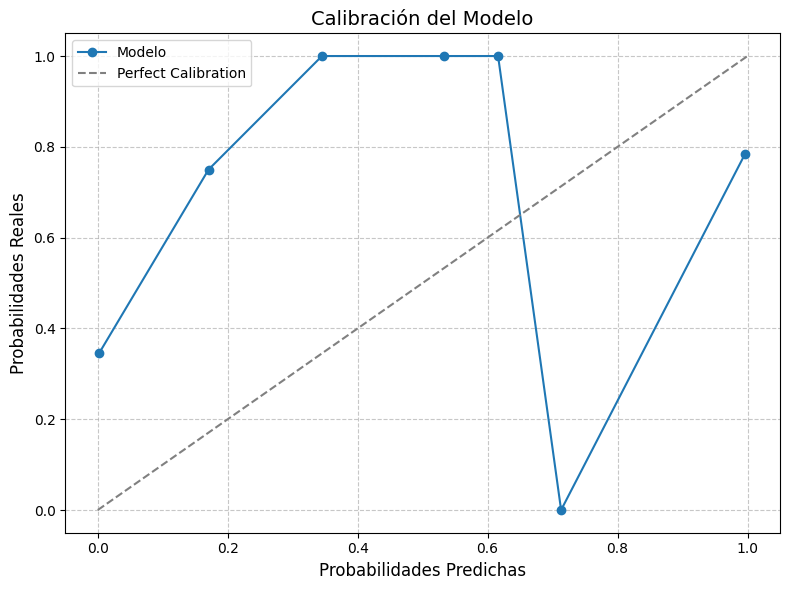

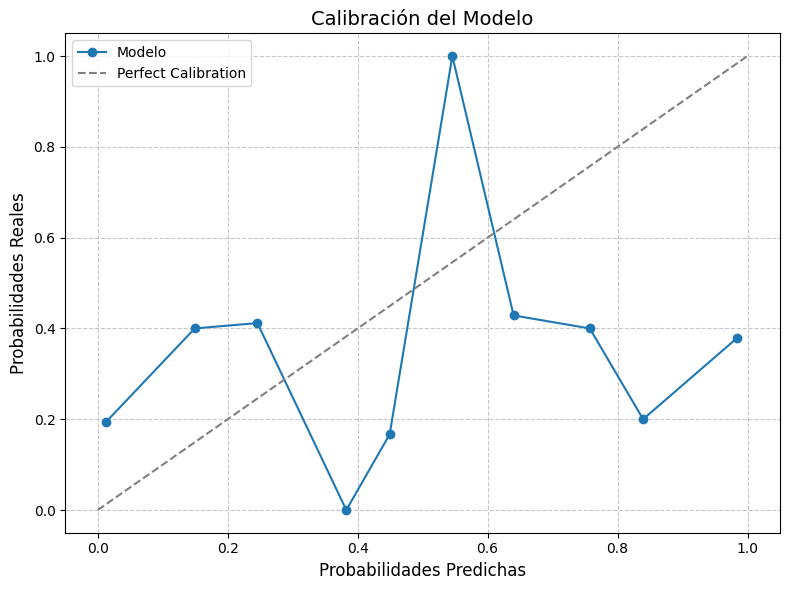

In [60]:
# Llamar a la función con los datos correctos
probabilidadReal(y_test, y_pred_prob)
probabilidadReal(y_test_desbalanceo, y_pred_prob_desbalanceo)
